# Golden Task 1 : Blindness Detection
<img src="https://images2.fanpop.com/image/photos/10300000/Cas-Blindness-castiel-10370846-640-352.jpg" alt="Sample Image" width="1200" height="900">


# Project Review

### Introduction:
This project delved into blindness detection using deep learning techniques, employing the ResNet-50 model. The goal was to contribute to medical diagnostics through AI-powered solutions.

### Approach:
By leveraging the ResNet-50 architecture for image classification, this project aimed to accurately identify different stages of blindness. The approach utilized transfer learning, making the most of the model's feature extraction capabilities.

### Dataset:
The ATOPS dataset from Kaggle served as the project's foundation. With a diverse range of blindness-related images, the dataset was crucial for effective training and testing of the deep learning model.

### Implementation:
The project meticulously covered data preprocessing, augmentation, model training, and evaluation. Transfer learning with ResNet-50 facilitated quick model convergence, and the well-organized code allows for easy replication and extension.

### Results:
The trained model's performance was evaluated using metrics like accuracy, precision, recall, and F1-score. The confusion matrix visually summarized the model's strengths and areas for improvement.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aptos2019-blindness-detection/sample_submission.csv
/kaggle/input/aptos2019-blindness-detection/train.csv
/kaggle/input/aptos2019-blindness-detection/test.csv
/kaggle/input/aptos2019-blindness-detection/train_images/ef476be214d4.png
/kaggle/input/aptos2019-blindness-detection/train_images/6dcde47060f9.png
/kaggle/input/aptos2019-blindness-detection/train_images/ec363f48867b.png
/kaggle/input/aptos2019-blindness-detection/train_images/17f6c7072f61.png
/kaggle/input/aptos2019-blindness-detection/train_images/b49b2fac2514.png
/kaggle/input/aptos2019-blindness-detection/train_images/af6166d57f13.png
/kaggle/input/aptos2019-blindness-detection/train_images/8d13c46e7d75.png
/kaggle/input/aptos2019-blindness-detection/train_images/c3b15bf9b4bc.png
/kaggle/input/aptos2019-blindness-detection/train_images/be68322c7223.png
/kaggle/input/aptos2019-blindness-detection/train_images/88e4399d207c.png
/kaggle/input/aptos2019-blindness-detection/train_images/0243404e8a00.png
/kaggle/input

# Importing Required Libraries

In [2]:
import os
import random
import warnings
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model
from keras import optimizers, applications
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# EDA

In [3]:
import tensorflow as tf

def seed_everything(seed=0):
    random.seed(seed)
    tf.random.set_seed(seed)
    

#Call the seed_everything function to set seeds
seed_everything()

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

In [4]:
train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

In [5]:
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])
display(train.head())

Number of train samples:  3662
Number of test samples:  1928


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


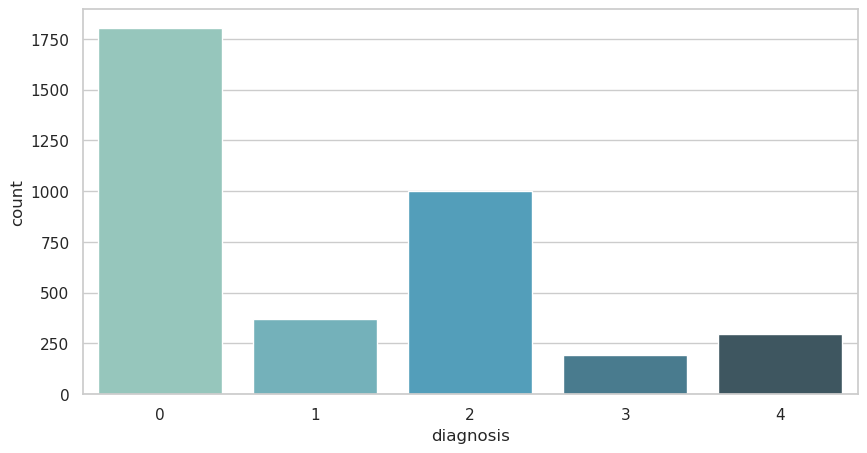

In [6]:
f, ax = plt.subplots(figsize=(10, 5))
ax = sns.countplot(x="diagnosis", data=train, palette="GnBu_d")
plt.show()

# Sample Training Images Visualization

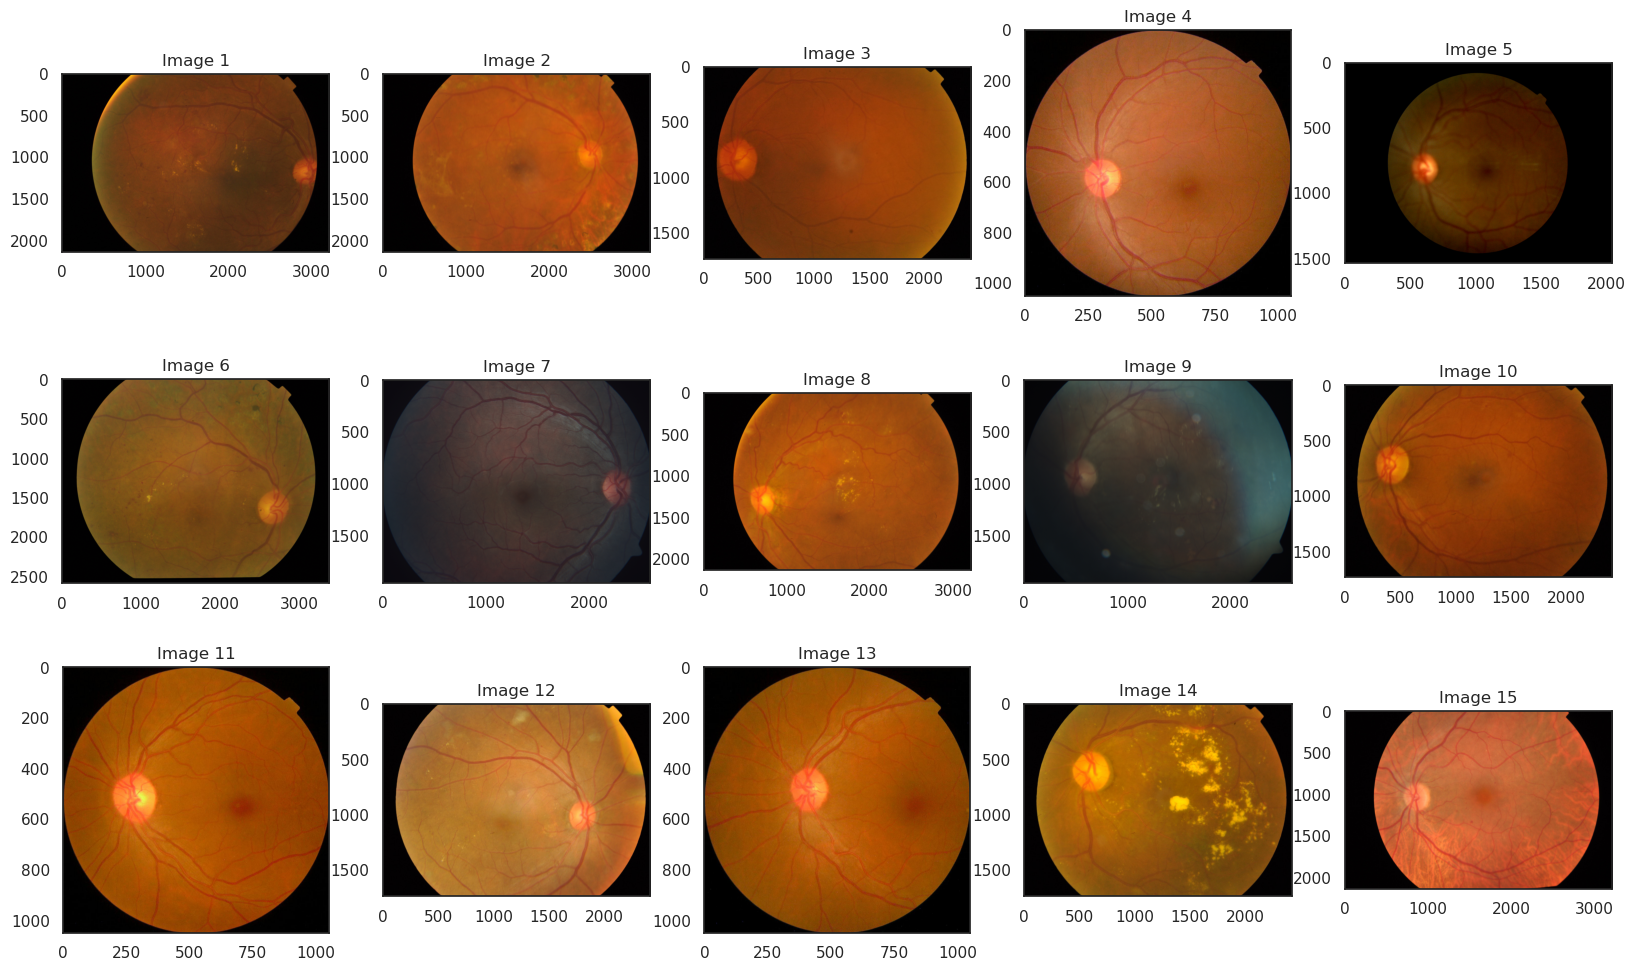

In [7]:
import cv2
sns.set_style("white")
count = 1
plt.figure(figsize=[20, 20])
for img_name in train['id_code'][:15]:
    img = cv2.imread("../input/aptos2019-blindness-detection/train_images/%s.png" % img_name)[...,[2, 1, 0]]
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title("Image %s" % count)
    count += 1
    
plt.show()

In [8]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 20
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 512
WIDTH = 512
CANAL = 3
N_CLASSES = train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

# Data Preprocessing 

In [9]:
# Preprocecss data
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')
train.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


# Data Generators Setup

In [10]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.2,
                                 horizontal_flip=True)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="../input/aptos2019-blindness-detection/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset='training')
valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="../input/aptos2019-blindness-detection/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",    
    target_size=(HEIGHT, WIDTH),
    subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "../input/aptos2019-blindness-detection/test_images/",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


# Model Creation Function

In [11]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.ResNet50(weights=None, 
                                       include_top=False,
                                       input_tensor=input_tensor)
    base_model.load_weights(tf.keras.utils.get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                                                 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'),
                        by_name=True)

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

# Model Initialization and Compilation

In [12]:
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True

metric_list = ["accuracy"]
optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model.summary()

94653016/94653016 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [13]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history_warmup = model.fit_generator(generator=train_generator, 
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,
                                     validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     verbose=1).history

Epoch 1/2
366/366 [==============================] - 579s 2s/step - loss: 1.3189 - accuracy: 0.4949 - val_loss: 1.3338 - val_accuracy: 0.4615
Epoch 2/2
366/366 [==============================] - 528s 1s/step - loss: 1.2981 - accuracy: 0.5003 - val_loss: 1.3359 - val_accuracy: 0.4615


# Model Fine-Tuning and Callbacks Setup

In [14]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=metric_list)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [15]:
history_finetunning = model.fit_generator(generator=train_generator,
                                         steps_per_epoch=STEP_SIZE_TRAIN,
                                         validation_data=valid_generator,
                                         validation_steps=STEP_SIZE_VALID,
                                         epochs=EPOCHS,
                                         callbacks=callback_list,
                                         verbose=1).history

Epoch 1/20
366/366 [==============================] - 561s 2s/step - loss: 2.2803 - accuracy: 0.5619 - val_loss: 0.6088 - val_accuracy: 0.2995 - lr: 1.0000e-04
Epoch 2/20
366/366 [==============================] - 507s 1s/step - loss: 0.3808 - accuracy: 0.6359 - val_loss: 0.4701 - val_accuracy: 0.4203 - lr: 1.0000e-04
Epoch 3/20
366/366 [==============================] - 502s 1s/step - loss: 0.3373 - accuracy: 0.6670 - val_loss: 0.3097 - val_accuracy: 0.6703 - lr: 1.0000e-04
Epoch 4/20
366/366 [==============================] - 510s 1s/step - loss: 0.3177 - accuracy: 0.6940 - val_loss: 0.3033 - val_accuracy: 0.6552 - lr: 1.0000e-04
Epoch 5/20
366/366 [==============================] - 514s 1s/step - loss: 0.2993 - accuracy: 0.6937 - val_loss: 0.2871 - val_accuracy: 0.6964 - lr: 1.0000e-04
Epoch 6/20
366/366 [==============================] - 456s 1s/step - loss: 0.2962 - accuracy: 0.7047 - val_loss: 0.3290 - val_accuracy: 0.6291 - lr: 1.0000e-04
Epoch 7/20
366/366 [====================

In [16]:
history = {
    'loss': history_warmup.get('loss', []) + history_finetunning.get('loss', []),
    'val_loss': history_warmup.get('val_loss', []) + history_finetunning.get('val_loss', []),
    'acc': history_warmup.get('acc', []) + history_finetunning.get('acc', []),
    'val_acc': history_warmup.get('val_acc', []) + history_finetunning.get('val_acc', [])
}

# Training Progress Visualization

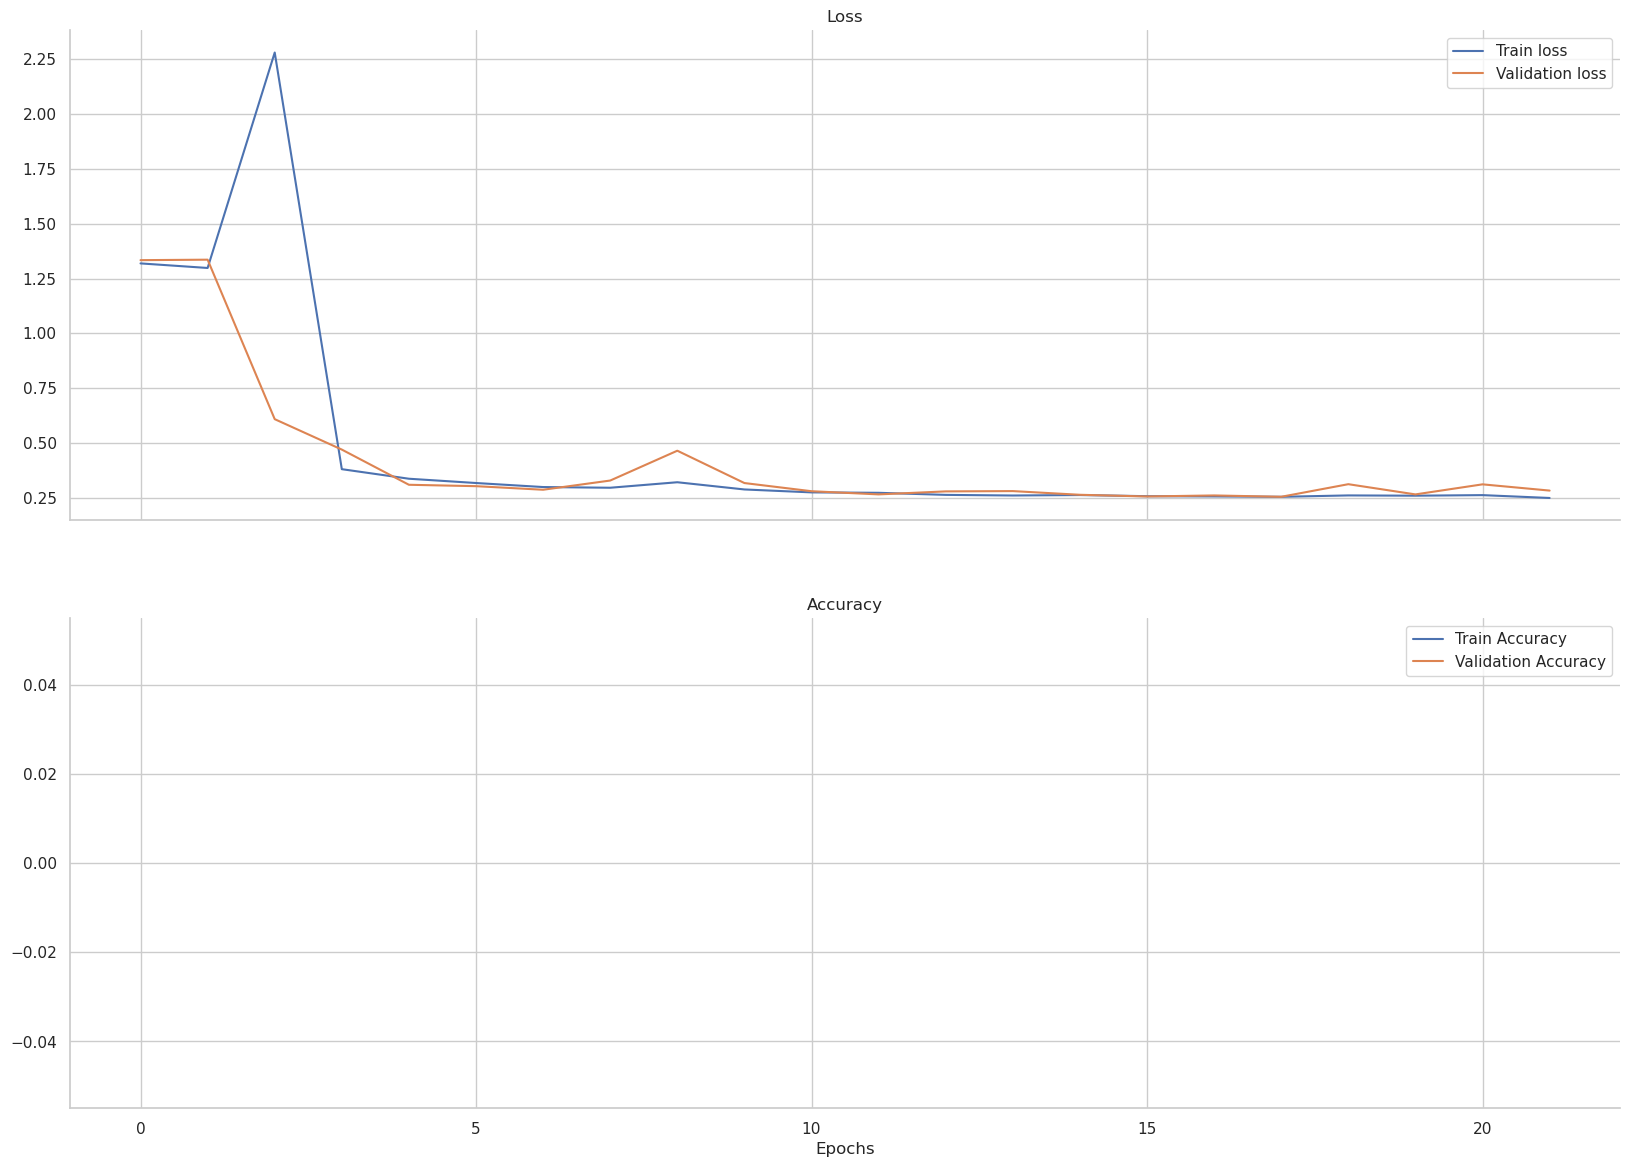

In [17]:
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2,1, sharex='col', figsize=(20,14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')
ax2.plot(history['acc'], label='Train Accuracy')
ax2.plot(history['val_acc'], label='Validation Accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [18]:
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(  
        dataframe=train,
        directory = "../input/aptos2019-blindness-detection/train_images/",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE)
train_preds = [np.argmax(pred) for pred in train_preds]

Found 3662 validated image filenames.


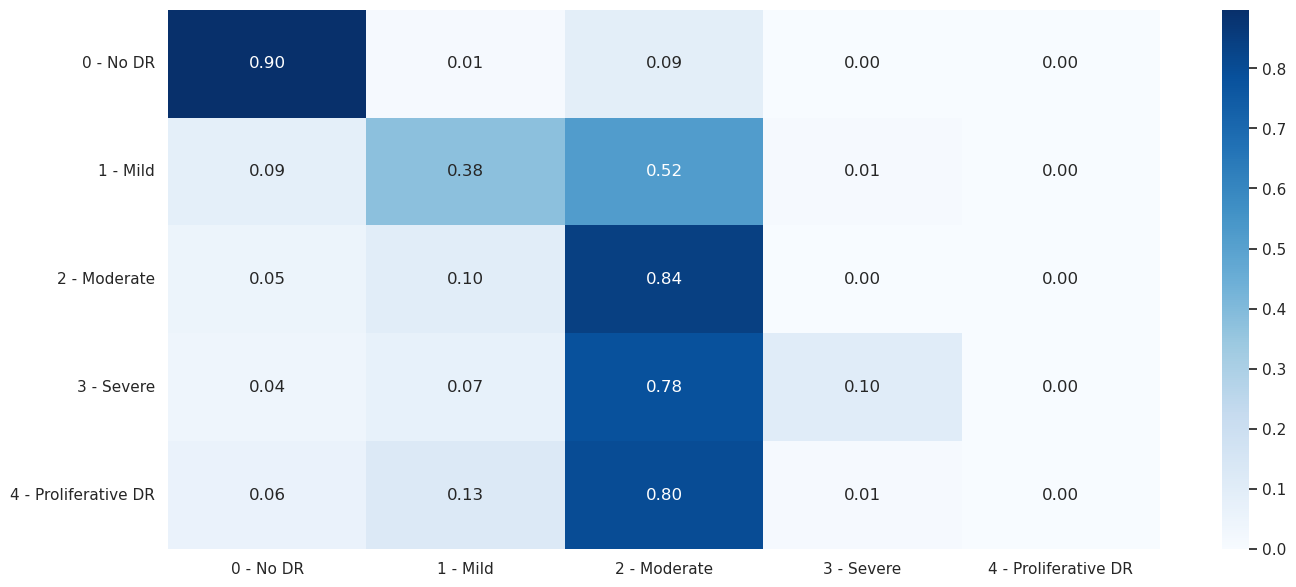

In [19]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(train['diagnosis'].astype('int'), train_preds)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

In [20]:
print("Train cohen Kappa score: %.3f"% cohen_kappa_score(train_preds, train['diagnosis'].astype('int'), weights='quadratic'))

Train cohen Kappa score: 0.682


# Test Set Predictions

In [21]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST)
predictions = [np.argmax(pred) for pred in preds]

In [22]:
filesnames = test_generator.filenames
results = pd.DataFrame({'id_code':filenames, 'diagnosis':predictions})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])
results.to_csv('submission.csv', index=False)
results.head(10)

,id_code,diagnosis
0,755615db51d3,2
1,d8f6c660bf2d,2
2,619ce2c77917,2
3,94a6e4f3c625,2
4,ee506d853270,2
5,acd52452b9a2,2
6,b0b0d564e6c6,2
7,228769e96741,0
8,a87e705d63ee,2
9,8c49d9de02d6,2


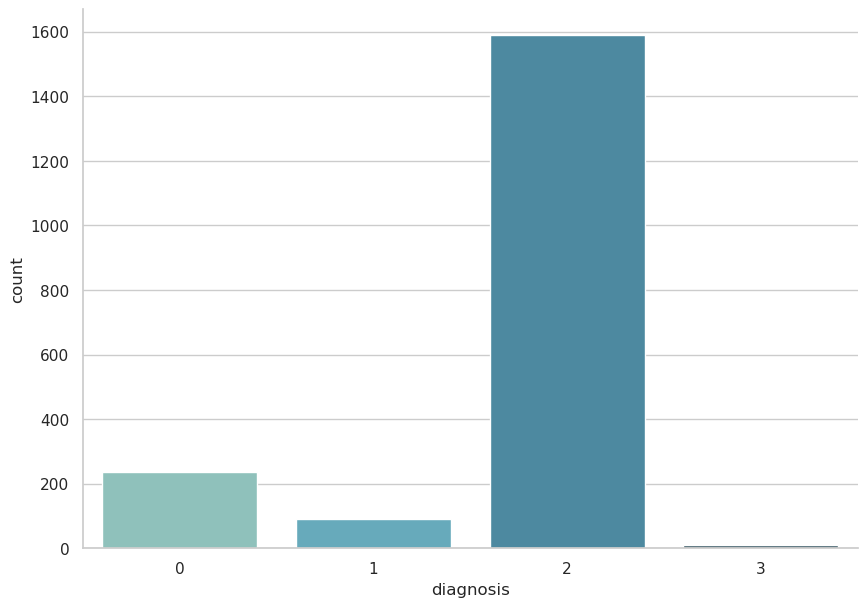

In [23]:
f, ax = plt.subplots(figsize=(10,7))
ax = sns.countplot(x="diagnosis", data=results, palette="GnBu_d")
sns.despine()
plt.show()